In [22]:
import sys
sys.path.append("../../src")
%load_ext autoreload
%autoreload 2

from typing import Callable, Dict, List
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder



import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from heatmap import heatmap
import statsmodels.formula.api as smf
import bioinfokit

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def preprocess_input_vars_ic_or(df:pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    ic_date = df["ic_date"]//10000
    ic_date = ic_date.replace(0, np.nan)

    df["age"] = ic_date - (df.date_of_birth//10000)
    
    df["age_gt_45"] = ((ic_date - (df.date_of_birth//10000)\
        .astype(int)) > 45)\
        .apply(lambda x: 1 if x else 0)
    
    df["age_lt_25"] = ((ic_date - (df.date_of_birth//10000)\
        .astype(int)) < 25)\
        .apply(lambda x: 1 if x else 0)
    
    df["gender_female"] = df.sex.transform(lambda x: 1 if x == "F" else 0)

    df = pd.concat(
        [df, pd.get_dummies(df.race, prefix="race").drop("race_W", axis=1)],
        axis=1
    )
    
    df["prior_commits"] = df.ic_prior_commits

    df["escape_hist_1"] = df.ic_escpe_hist_1.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["escape_hist_2"] = df.ic_escpe_hist_2.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["escape_hist_3"] = df.ic_escpe_hist_3.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["escape_hist_4"] = df.ic_escpe_hist_4.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["escape_hist_5"] = df.ic_escpe_hist_5.transform(
        lambda x: 1 if str(x) == "X" else 0
    )

    df["escape_hist"] = (
        df["escape_hist_1"] +
        df["escape_hist_2"] +
        df["escape_hist_3"] +
        df["escape_hist_4"] +
        df["escape_hist_5"]
    )

    df = pd.concat(
        [
            df,
            pd.get_dummies(df.ic_mrtl_stat_fr_cl, prefix="mrt_stat")\
                .drop(["mrt_stat_SIN", "mrt_stat_UNK"], axis=1)
        ],
        axis=1
    )

    df["maritial_status"] = LabelEncoder().fit_transform(df["ic_mrtl_stat_fr_cl"])

    df["employed"] = df.ic_employ_ind.fillna(0).replace("X", 1)

    df["race"] = LabelEncoder().fit_transform(df["race"])
    
    
    temp_var = "prob_alcohol"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)
    df[temp_var] = df[temp_var].replace(np.nan, 0)
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_drugs"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_assault"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    temp_var = "prob_sexual"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    temp_var = "prob_psyco"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_suicide"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_escape"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    df["problematic_conditions"] = (df["prob_escape"] 
                                    + df["prob_alcohol"] 
                                    + df["prob_assault"]
                                    + df["prob_drugs"] 
                                    + df["prob_escape"] 
                                    + df["prob_psyco"]
                                    + df["prob_sexual"]
                                    + df["prob_suicide"])
    
    temp_var = "problematic_offenses"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('N', 0)    
    df[temp_var] = df[temp_var].replace('Y', 1)    
    
    return df


## Overrides during initial classification

In [24]:
df = pd.read_csv("../../data/initial_custody_2017_gsprs.csv", low_memory=False)

df['high_ic_instit_adj'] = np.where(df['ic_institut_adj']>2, 1, 0)
df['ic_override_up'] = np.where(df['ic_ovride_cust_lvl']-df['ic_custdy_level']>0,1,0)
df['high_ic'] = np.where(df['ic_custdy_level']>3, 1, 0)

data = preprocess_input_vars_ic_or(df)

data_ic_or = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "ic_custdy_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "problematic_offenses",
        "problematic_conditions",
        "ic_override_up"
    ]
]

data_ic_or = data_ic_or.dropna()

In [25]:
data_ic_or['ic_override_up'].value_counts()

0    13563
1      253
Name: ic_override_up, dtype: int64

In [26]:
X = data_ic_or.loc[:, data_ic_or.columns != 'ic_override_up']
y = data_ic_or.loc[:, data_ic_or.columns == 'ic_override_up']

### Balance classes

In [27]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

X_os, y_os = os.fit_resample(X, y)

### Recursive feature elimination

In [28]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(max_iter=500) # increase the number of iterations to get convergence

rfe = RFE(logreg, n_features_to_select=8, step=1)
rfe = rfe.fit(X_os, y_os.values.ravel())

zz= list(zip(X_os.columns,list(rfe.support_)))

ll = [a for (a,b) in zz if b]

ll


/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['race_A',
 'race_O',
 'escape_hist_1',
 'escape_hist_2',
 'escape_hist_3',
 'escape_hist_4',
 'escape_hist_5',
 'mrt_stat_SEP']

In [29]:
ll.append('race_B')
ll.append('gender_female')
ll.append('problematic_conditions')
ll.append('problematic_offenses')
ll.append('age_lt_25')
ll.append('age_gt_45')
ll.append('ic_institut_adj')

X = X[ll]

logit_model=sm.Logit(y,X.astype(float))
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)

Optimization terminated successfully.
         Current function value: 0.091245
         Iterations 9
                            Results: Logit
Model:                 Logit              Pseudo R-squared:   0.002    
Dependent Variable:    ic_override_up     AIC:                2551.2898
Date:                  2021-10-02 01:37   BIC:                2664.2935
No. Observations:      13816              Log-Likelihood:     -1260.6  
Df Model:              14                 LL-Null:            -1262.7  
Df Residuals:          13801              LLR p-value:        0.99452  
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        9.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
race_A                  0.1020   1.0339   0.0987 0.9214 -1.9245

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of logistic regression classifier on test set: 0.72
[[2936 1134]
 [  32   43]]
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      4070
           1       0.04      0.57      0.07        75

    accuracy                           0.72      4145
   macro avg       0.51      0.65      0.45      4145
weighted avg       0.97      0.72      0.82      4145



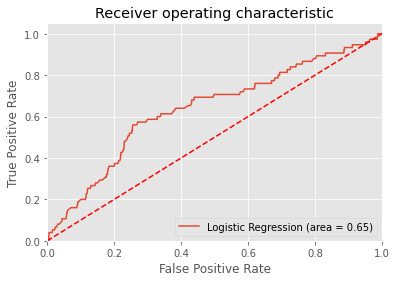

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_os, y_train_os = os.fit_resample(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_train_os, y_train_os.values.ravel())

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Overrides during reclassification

In [31]:
def preprocess_input_vars_re_or(df:pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    re_date = df["re_de_year"]
    re_date = re_date.replace(0, np.nan)
    
    df["re_ovride_cust_lvl"] = df["re_ovride_cust_lvl"].replace(" ", np.nan)
    df["re_ovride_cust_lvl"] = df["re_ovride_cust_lvl"].replace("", np.nan)
    
    df["re_ovride_cust_lvl"] = df["re_ovride_cust_lvl"].astype(float)
    
    
    df["age"] = re_date - (df.date_of_birth//10000)

    df["age_gt_45"] = ((re_date - (df.date_of_birth//10000)\
        .astype(int)) > 45)\
        .apply(lambda x: 1 if x else 0)
    
    df["age_lt_25"] = ((re_date - (df.date_of_birth//10000)\
        .astype(int)) < 25)\
        .apply(lambda x: 1 if x else 0)
    
    df["gender_female"] = df.sex.transform(lambda x: 1 if x == "F" else 0)

    df = pd.concat(
        [df, pd.get_dummies(df.race, prefix="race").drop("race_W", axis=1)],
        axis=1
    )
    
    df["prior_commits"] = df.ic_prior_commits

    df["re_escp_hist_1"] = df.re_escp_hist_1.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["re_escp_hist_2"] = df.re_escp_hist_2.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["re_escp_hist_3"] = df.re_escp_hist_3.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["re_escp_hist_4"] = df.re_escp_hist_4.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["re_escp_hist_5"] = df.re_escp_hist_5.transform(
        lambda x: 1 if str(x) == "X" else 0
    )

    df["escape_hist"] = (
        df["re_escp_hist_1"] +
        df["re_escp_hist_2"] +
        df["re_escp_hist_3"] +
        df["re_escp_hist_4"] +
        df["re_escp_hist_5"]
    )
    
    
    df = pd.concat(
        [
            df,
            pd.get_dummies(df.ic_mrtl_stat_fr_cl, prefix="mrt_stat")\
                .drop(["mrt_stat_SIN", "mrt_stat_UNK"], axis=1)
        ],
        axis=1
    )

    df["marital_status"] = LabelEncoder().fit_transform(df["ic_mrtl_stat_fr_cl"])

    df["race"] = LabelEncoder().fit_transform(df["race"])
    

    df["employed"] = df.ic_employ_ind.fillna(0).replace("X", 1)
    
    
    temp_var = "prob_alcohol"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)
    df[temp_var] = df[temp_var].replace(np.nan, 0)
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_drugs"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_assault"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    temp_var = "prob_sexual"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    temp_var = "prob_psyco"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_suicide"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_escape"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    df["problematic_conditions"] = (df["prob_escape"] 
                                    + df["prob_alcohol"] 
                                    + df["prob_assault"]
                                    + df["prob_drugs"] 
                                    + df["prob_escape"] 
                                    + df["prob_psyco"]
                                    + df["prob_sexual"]
                                    + df["prob_suicide"])
    
    temp_var = "problematic_offenses"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('N', 0)    
    df[temp_var] = df[temp_var].replace('Y', 1)    
    
    #df['re_ovride_cust_lvl'] = df['re_ovride_cust_lvl'].replace(np.nan, np.n)
    #df['re_custody_level'] = df['re_ovride_cust_lvl'].replace(np.nan, 0)
    return df


In [32]:
df = pd.read_csv("../../data/re_custody_2017_gsprs.csv", low_memory=False)

df['re_ovride_cust_lvl'] = df['re_ovride_cust_lvl'].replace(' ', np.nan)



In [33]:
df['re_override_up'] = np.where(df['re_ovride_cust_lvl'].astype(float)-df['re_custody_level']>0,1,0)
df['high_re'] = np.where(df['re_custody_level']>3, 1, 0)



In [34]:
data = preprocess_input_vars_re_or(df)



In [35]:
data_re_or = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "prior_commits",
        "re_discip_reports",
        "re_escp_hist_1",
        "re_escp_hist_2",
        "re_escp_hist_3",
        "re_escp_hist_4",
        "re_escp_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "problematic_offenses",
        "problematic_conditions",
        "re_override_up",
        "re_custody_level"
    ]
]

data_re_or = data_re_or.dropna()

In [36]:
data_re_or['problematic_conditions'].value_counts()

3    4524
2    3886
4    3048
5    1922
1    1920
6     818
7     234
0     121
8      70
Name: problematic_conditions, dtype: int64

In [37]:
X = data_re_or.loc[:, data_re_or.columns != 're_override_up']
y = data_re_or.loc[:, data_re_or.columns == 're_override_up']

### Balance classes

In [38]:
os = SMOTE(random_state=0)

X_os, y_os = os.fit_resample(X,y)

In [39]:
X.columns

Index(['gender_female', 'age_gt_45', 'age_lt_25', 'race_B', 'race_A', 'race_H',
       'race_I', 'race_O', 'off_1_prs_max', 'off_1_gs_max', 'prior_commits',
       're_discip_reports', 're_escp_hist_1', 're_escp_hist_2',
       're_escp_hist_3', 're_escp_hist_4', 're_escp_hist_5', 'mrt_stat_DIV',
       'mrt_stat_SEP', 'mrt_stat_MAR', 'mrt_stat_WID', 'employed',
       'problematic_offenses', 'problematic_conditions', 're_custody_level'],
      dtype='object')

### RFE

In [40]:
logreg = LogisticRegression(max_iter=500) # increase the number of iterations to get convergence

rfe = RFE(logreg, n_features_to_select=8, step=1)
rfe = rfe.fit(X_os, y_os.values.ravel())

zz= list(zip(X_os.columns,list(rfe.support_)))

ll = [a for (a,b) in zz if b]

ll

['gender_female',
 'age_lt_25',
 're_escp_hist_1',
 're_escp_hist_2',
 're_escp_hist_4',
 'mrt_stat_DIV',
 'mrt_stat_SEP',
 'problematic_offenses']

In [41]:
ll.append('race_B')
ll.append('problematic_conditions')
ll.append('age_gt_45')
ll.append('re_discip_reports')

X = X[ll]

logit_model=sm.Logit(y,X.astype(float))
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)

Optimization terminated successfully.
         Current function value: 0.335093
         Iterations 8
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.263     
Dependent Variable:   re_override_up     AIC:                11110.8830
Date:                 2021-10-02 01:38   BIC:                11203.4477
No. Observations:     16543              Log-Likelihood:     -5543.4   
Df Model:             11                 LL-Null:            -7517.4   
Df Residuals:         16531              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       8.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
gender_female          -0.4956   0.1844  -2.6879 0.0072 -0.8569

Accuracy of logistic regression classifier on test set: 0.76
[[3090  997]
 [ 193  683]]
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      4087
           1       0.41      0.78      0.53       876

    accuracy                           0.76      4963
   macro avg       0.67      0.77      0.69      4963
weighted avg       0.85      0.76      0.78      4963



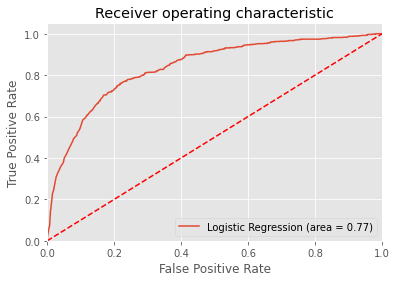

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)



X_train_os, y_train_os = os.fit_resample(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_train_os, y_train_os.values.ravel())

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [43]:
X_test.columns

Index(['gender_female', 'age_lt_25', 're_escp_hist_1', 're_escp_hist_2',
       're_escp_hist_4', 'mrt_stat_DIV', 'mrt_stat_SEP',
       'problematic_offenses', 'race_B', 'problematic_conditions', 'age_gt_45',
       're_discip_reports'],
      dtype='object')